In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import plot_confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
%matplotlib inline

In [2]:
# Organize data into train, valid, test dirs

if os.path.isdir('data/train/dog') is False:
    os.makedirs('data/train/dog')
    os.makedirs('data/train/cat')
    os.makedirs('data/valid/dog')
    os.makedirs('data/valid/cat')
    os.makedirs('data/test/dog')
    os.makedirs('data/test/cat')

    for i in random.sample(glob.glob('data/all/cat*'), 500):
        shutil.move(i, 'data/train/cat')
    for i in random.sample(glob.glob('data/all/dog*'), 500):
        shutil.move(i, 'data/train/dog')
    for i in random.sample(glob.glob('data/all/cat*'), 100):
        shutil.move(i, 'data/valid/cat')
    for i in random.sample(glob.glob('data/all/dog*'), 100):
        shutil.move(i, 'data/valid/dog')
    for i in random.sample(glob.glob('data/all/cat*'), 50):
        shutil.move(i, 'data/test/cat')
    for i in random.sample(glob.glob('data/all/dog*'), 50):
        shutil.move(i, 'data/test/dog')

In [3]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [14]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

earlystop = keras.callbacks.EarlyStopping(patience = 10, monitor = 'val_accuracy')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [19]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

# model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [27]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	# plt.close()

In [28]:
history = model.fit(x=train_batches,
    # steps_per_epoch=len(train_batches),
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=2,
    verbose=1
)

Epoch 1/2
100/100 [==============================] - 21s 208ms/step - loss: 2.2340 - accuracy: 0.9160 - val_loss: 5.2289 - val_accuracy: 0.6150
Epoch 2/2
100/100 [==============================] - 25s 249ms/step - loss: 0.7876 - accuracy: 0.9560 - val_loss: 7.4887 - val_accuracy: 0.6200


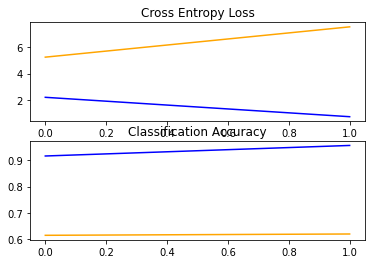

In [29]:
summarize_diagnostics(history)

In [7]:
# Predict a batch
test_imgs, test_labels = next(test_batches)

In [8]:
single_image = test_imgs[0]

In [9]:
single_image = np.expand_dims(single_image, 0)

In [10]:
np.expand_dims

<function numpy.expand_dims(a, axis)>

In [11]:
# predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
predictions = model.predict(x=single_image, verbose=1)
predictions

1/1 [==============================] - 0s 81ms/step


array([[9.995005e-01, 4.995255e-04]], dtype=float32)

In [12]:
predictions

array([[9.995005e-01, 4.995255e-04]], dtype=float32)

In [13]:
np.round(predictions)

array([[1., 0.]], dtype=float32)